In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# For feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

c:\Users\daphn\anaconda3\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    if len(loss_record['dev'])!=0:
        x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
        plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 20.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [4]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        
        #Opens the file located at path in read mode and assigns it to the file object fp. The with statement ensures that the file is properly closed after its suite finishes.
        with open(path, 'r') as fp:
            # Uses the csv.reader method to read the file fp line-by-line and converts the output to a list. Each line from the file is turned into a list of strings.
            data = list(csv.reader(fp))
            # Converts the list of lists (excluding the first row) to a numpy array. The [1:] slice is used to exclude the first row.
            #[:, 1:] - This is a numpy slice operation that selects all rows and all columns except the first column.
            data = np.array(data[1:])[:, 1:].astype(float)

        
        if not target_only: #feats: 要考慮的特徵
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)   
            # 這邊使用 DAY1 的 4 種 COVID-like illness(40, 41, 42, 43) 和 DAY2 的 4 種 COVID-like illness (58, 59, 60, 61) 和 DAY3 的 4 種 COVID-like illness (76, 77, 78, 79) 
            #mutual_info 通常指的是 "mutual information"（互信息），它是一種測量兩個隨機變量之間相互依賴程度的方法。在機器學習和特徵選擇的上下文中，互信息可以用來確定特征與目標變量之間的關聯性。scikit-learn（通常縮寫為 sklearn）提供了用於計算特征與目標之間的互信息的方法。這些方法常常被用於特徵選擇。
            feats = [40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79] # sklean mutual info
            
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1] # 最後一個column是target
            data = data[:, feats] # feats: 要考慮的特徵
            # 整個train+val一起mean/std
            """
            torch.FloatTensor(data):This converts the data (presumably a numpy array or a list) into a PyTorch FloatTensor. FloatTensor is a multi-dimensional matrix containing elements of a single data type (in this case, float).
            
            .mean(dim=0, keepdim=True):Calculates the mean of the FloatTensor along dimension 0 (i.e., for each feature/column, if the data is 2D with rows as samples and columns as features).
            dim=0 means that it will calculate the mean for each column.
            keepdim=True ensures that the returned tensor maintains the same number of dimensions. For instance, if data is of shape (batch_size, num_features), without keepdim, the mean would be of shape (num_features,). But with keepdim=True, it would be (1, num_features).
            
            .std(dim=0, keepdim=True):
            Similarly, this calculates the standard deviation of the FloatTensor along dimension 0 (for each feature/column).
            Just like with mean, keepdim=True ensures the result maintains the same number of dimensions.
            """
            self.mean = torch.FloatTensor(data).mean(dim=0, keepdim=True)
            self.std = torch.FloatTensor(data).std(dim=0, keepdim=True)
        
                
            # Splitting training data into train & dev sets
            # This strategy effectively separates 20% of the data for validation (1 out of every 5 samples) and the remaining 80% for training.
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 5 != 0]
                
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 5 == 0]


            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])


        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)
    # Normalization is a common preprocessing step in machine learning that ensures features have the same scale, which is important for models that rely on the weighted sum of input features, like linear regression.
    def normalization(self, mean=None, std=None):
        # Normalize features (you may remove this part to see what will happen)
        # The mean and standard variance of training data will be reused to normalize testing data.
        if self.mode == 'train' or self.mode =='dev':
            mean = self.mean
            std = self.std 
            self.data =  (self.data-mean) / std #If the dataset's mode is 'train' or 'dev', then the method uses the internally stored self.mean and self.std for normalization. This makes sense because during training and validation, you'd typically want to normalize data based on statistics from the training set.
            
        else:
            self.data =  (self.data-mean) / std
            # 為何 test 也要 normalize? 因為要確保資料 scale 一致，才能讓 model 在 training 和 testing 時都能得到一致的結果。
            # Normalizing the test set is critical for maintaining consistency in the data preprocessing pipeline, ensuring that the model receives data in the same format and scale during both training and testing.
            
        return mean, std

In [5]:
"""_summary_
    The `prep_dataloader` function is designed to prepare a PyTorch dataloader for the COVID19 dataset. Dataloaders are a crucial part of PyTorch's data utilities that provide an easy way to feed data in batches, shuffle data, and leverage multi-threading while loading data. Here's a breakdown of the function:

1. **Function Arguments**:
    - `path`: The path to the dataset.
    - `mode`: Mode of the dataset, which can be 'train', 'dev', 'test', etc.
    - `batch_size`: Size of each batch of data.
    - `n_jobs`: Number of subprocesses to use for data loading (default is 0, which means the data will be loaded in the main process).
    - `target_only`: Whether to use a subset of the features (as specified in the `COVID19Dataset` class).
    - `mean` and `std`: Pre-calculated mean and standard deviation values for normalization. If they are not provided, the function will use the mean and std from the training data.

2. **Dataset Creation**:
    - The function starts by creating a `COVID19Dataset` object using the given `path`, `mode`, and `target_only` parameters.

3. **Normalization**:
    - The dataset is then normalized using the `normalization` method of the `COVID19Dataset` class. If `mean` and `std` values are provided, they are used; otherwise, the function computes them from the dataset. The normalization function returns the mean and std used, which can be handy for ensuring the test set is normalized using the training set's statistics.

4. **Dataloader Construction**:
    - A PyTorch `DataLoader` is then created, which will handle batching, shuffling, and multi-threading for the dataset.
    - `shuffle=(mode == 'train')`: Data is shuffled only if the mode is 'train'. Shuffling helps in breaking any patterns in the data during training.
    - `drop_last=False`: Whether to drop the last batch if its size is smaller than `batch_size`.
    - `num_workers=n_jobs`: The number of subprocesses to use for data loading.
    - `pin_memory=True`: If `True`, the data loader will copy tensors into CUDA pinned memory before returning them. Useful when training on GPUs.

5. **Return**:
    - The function returns the constructed `dataloader`, as well as the `mean` and `std` used for normalization.

Overall, the `prep_dataloader` function simplifies the data preparation process for training/testing a machine learning model on the COVID19 dataset by encapsulating the dataset creation, normalization, and dataloader construction steps into a single function call.
"""
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, mean=None, std=None):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    mean, std = dataset.normalization(mean, std)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader, mean, std

In [6]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?

        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8,4),
            nn.ReLU(),
            nn.Linear(4,1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, l1_lambda):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        loss = self.criterion(pred, target) 
        
        # L1 regularization
        l1_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l1_reg += torch.sum(torch.abs(param))
        loss += l1_lambda * l1_reg
        
        return loss

In [7]:
"""
The provided function, `train`, is responsible for training a neural network model for a given number of epochs or until an early stopping criterion is met. The function records the loss on both training and validation datasets, and it saves the model parameters whenever it achieves a lower Mean Squared Error (MSE) on the validation set.

Let's break down the function step by step:

1. **Function Arguments**:
    - `tr_set`: Training dataset.
    - `dv_set`: Validation (development) dataset.
    - `model`: The neural network model to be trained.
    - `config`: A dictionary that includes configuration parameters such as number of epochs, optimizer settings, early stopping criterion, L1 regularization strength, and path to save the model.
    - `device`: The computing device (e.g., CPU or GPU) to which tensors will be moved.

2. **Setup & Initialization**:
    - Set the maximum number of training epochs.
    - Initialize the optimizer using the optimizer type and hyperparameters specified in `config`.
    - Define variables for tracking the best MSE, training and validation loss records, early stopping count, and current epoch number.

3. **Training Loop**:
    - Each epoch consists of:
        - Setting the model to training mode.
        - Iterating through batches of the training dataset.
        - For each batch:
            - Clear the gradients of the model parameters.
            - Move the batch to the specified device.
            - Perform a forward pass to get the model's predictions.
            - Calculate the loss using both MSE and L1 regularization.
            - Backpropagate the loss to compute gradients.
            - Update the model's parameters using the optimizer.
            - Record the training loss.

4. **Validation**:
    - After each epoch, validate the model on the `dv_set` using the `dev` function (not provided in the snippet) to calculate the MSE on the validation set.
    - If the MSE on the validation set is lower than the previous best, save the model parameters and reset the early stopping counter.
    - If not, increment the early stopping counter.
    - If the early stopping counter exceeds the threshold specified in `config`, break out of the training loop.

5. **Return**:
    - The function returns the best MSE achieved on the validation set and the recorded training and validation losses.

6. **Early Stopping**:
    - This is a regularization technique to avoid overfitting. If the model doesn't improve on the validation set for a certain number of consecutive epochs (specified by `config['early_stop']`), training is stopped. This helps in preventing the model from overfitting to the training data by stopping training once the model starts to perform worse on the validation data.

This function provides a good template for training neural network models using PyTorch. It incorporates key training practices like early stopping and regularization, and it also records losses for potential analysis or visualization.
"""
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y, config['l1_lambda'])  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())
            
        
        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, val_loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [8]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y, config['l1_lambda'])  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [9]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [10]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

seed = 459
np.random.seed(seed)
delta = np.random.normal(loc=0,scale = 0.000001)

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',             # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.003,                 # learning rate of Adam
        #'weight_decay': 1e-8        # weight decay (L2 regularization)  
    },
    'l1_lambda':1e-5 + delta,        # L1 regularization
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}


myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [11]:
tr_set, mean, std = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set, _, _ = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only, mean=mean, std=std)
tt_set, _, _ = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only, mean=mean, std=std)

Finished reading the train set of COVID19 Dataset (2160 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (540 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


In [12]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [13]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, val_loss = 300.2631)
Saving model (epoch =    2, val_loss = 274.2977)
Saving model (epoch =    3, val_loss = 214.0072)
Saving model (epoch =    4, val_loss = 113.5368)
Saving model (epoch =    5, val_loss = 90.2621)
Saving model (epoch =    6, val_loss = 73.3386)
Saving model (epoch =    7, val_loss = 70.5106)
Saving model (epoch =    8, val_loss = 60.1677)
Saving model (epoch =    9, val_loss = 53.4522)
Saving model (epoch =   10, val_loss = 44.6502)
Saving model (epoch =   11, val_loss = 35.8761)
Saving model (epoch =   12, val_loss = 26.7332)
Saving model (epoch =   13, val_loss = 18.8765)
Saving model (epoch =   14, val_loss = 12.7268)
Saving model (epoch =   15, val_loss = 8.6071)
Saving model (epoch =   16, val_loss = 5.5794)
Saving model (epoch =   17, val_loss = 3.6095)
Saving model (epoch =   18, val_loss = 2.4284)
Saving model (epoch =   19, val_loss = 2.0233)
Saving model (epoch =   20, val_loss = 1.8179)
Saving model (epoch =   21, val_loss = 1.6

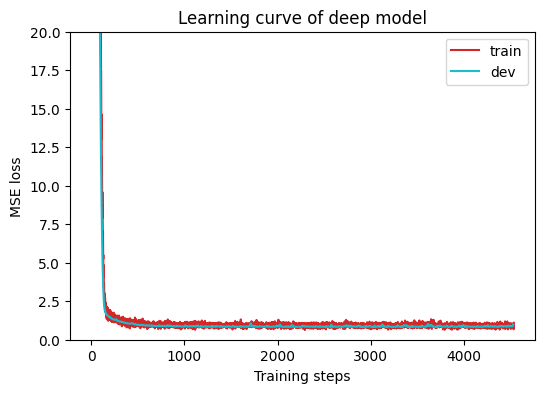

In [14]:
plot_learning_curve(model_loss_record, title='deep model')

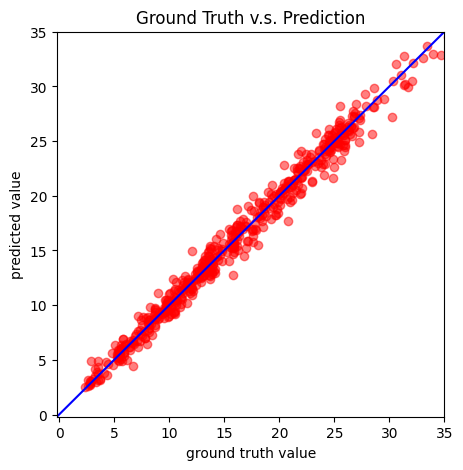

In [15]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
if len(dv_set) > 0:
    plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [16]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# I use the sample code from TA.